# DSC 232R: Week 4 Discussion
## Linear Algebra Review, Matrix Notation, and PCA

**Agenda:**
1.  **Vectors & Geometry:** Reviewing norms, dot products, and orthogonality.
2.  **Matrix Notation:** Understanding matrices as collections of vectors and change of basis.
3.  **PCA (Theory):** How covariance and eigenvectors help us find the best basis.
4.  **PCA (Application):** Compressing the MNIST handwritten digits dataset.

---

## Part 1: Review of Linear Algebra

### 1.1 Vectors as Arrays
In Computer Science, we often treat vectors as 1D arrays of numbers. Geometrically, they are arrows with **direction** and **magnitude**.

Let's define two vectors, $\mathbf{v_1}$ and $\mathbf{v_2}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Set plotting style
plt.style.use('ggplot')
np.set_printoptions(precision=2, suppress=True)

# 1. Define Vectors
v1 = np.array([2, 5])
v2 = np.array([1, -1])

print(f"Vector v1: {v1}")
print(f"Vector v2: {v2}")

Vector v1: [2 5]
Vector v2: [ 1 -1]


### 1.2 The Dot Product
The dot product is crucial for PCA. It tells us how much one vector aligns with another.

$$ \mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i = ||a|| ||b|| \cos(\theta) $$

* **Positive:** Pointing in similar direction.
* **Zero:** Orthogonal (90 degrees, no correlation).
* **Negative:** Pointing in opposite directions.

In [2]:
# Calculate Dot Product
# Manual: (2 * 1) + (5 * -1) = 2 - 5 = -3
dot_prod = np.dot(v1, v2)

print(f"Dot Product (v1 . v2): {dot_prod}")

# Check Orthogonality of basis vectors
e1 = np.array([1, 0])
e2 = np.array([0, 1])
print(f"Dot Product of standard basis [1,0] and [0,1]: {np.dot(e1, e2)} (Orthogonal)")

Dot Product (v1 . v2): -3
Dot Product of standard basis [1,0] and [0,1]: 0 (Orthogonal)


### 1.3 Visualizing Vectors
Let's see what these look like in 2D space.

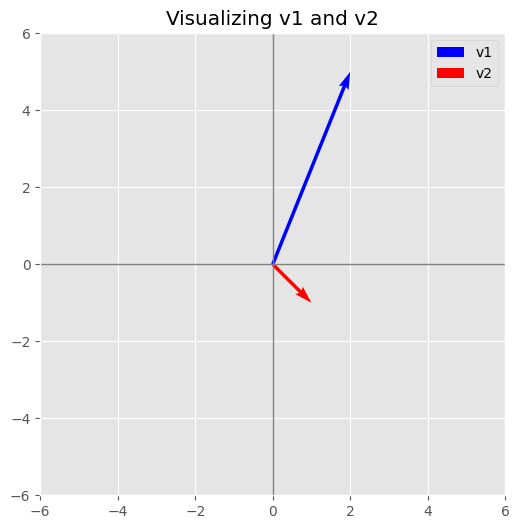

In [3]:
def plot_vectors(vectors, colors, title="Vectors"):
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)

    for i, vec in enumerate(vectors):
        # quiver plots arrows: (x_start, y_start, x_direction, y_direction)
        plt.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color=colors[i], label=f'v{i+1}')

    limit = np.max(np.abs(vectors)) + 1
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

plot_vectors([v1, v2], ['blue', 'red'], title="Visualizing v1 and v2")

---
## Part 2: Matrix Notation

A matrix can be viewed as a **collection of vectors**.

$$ A = \begin{bmatrix} | & | \\ \mathbf{c_1} & \mathbf{c_2} \\ | & | \end{bmatrix} $$

### 2.1 Matrix-Vector Multiplication
Multiplying a matrix $A$ by a vector $x$ is equivalent to taking a **linear combination** of the columns of $A$.

In [4]:
# Define Matrix A (Columns are vectors)
A = np.array([
    [1, 2],
    [3, 4],
    [5, 6]
])

print("Matrix A (3x2):\n", A)

# Define vector x
x = np.array([10, 20])

# Compute Ax
Ax = np.dot(A, x)
print("\nVector x:", x)
print("Result Ax (Linear Combination):\n", Ax)

# Verification: 10 * [1,3,5] + 20 * [2,4,6]
verification = 10 * A[:, 0] + 20 * A[:, 1]
print("Verification:\n", verification)

Matrix A (3x2):
 [[1 2]
 [3 4]
 [5 6]]

Vector x: [10 20]
Result Ax (Linear Combination):
 [ 50 110 170]
Verification:
 [ 50 110 170]


### 2.2 Orthonormal Basis & Change of Basis
An **orthonormal matrix** $U$ is special:
1.  Its columns are unit vectors ($||u||=1$).
2.  Its columns are orthogonal ($u_i \cdot u_j = 0$).

**Key Property:**
$$ U^T U = I $$
This means the **transpose** acts as the **inverse**.

This allows us to project data into a new coordinate system easily.

In [5]:
# Create an orthonormal basis (Rotation by 45 degrees)
theta = np.radians(45)
u1 = np.array([np.cos(theta), np.sin(theta)])
u2 = np.array([-np.sin(theta), np.cos(theta)])

# Stack into Matrix U
U = np.stack([u1, u2], axis=1)
print("Orthonormal Matrix U:\n", U)

# Verify Property U.T @ U = I
I_approx = np.dot(U.T, U)
print("\nU^T U (Should be Identity):\n", I_approx)

Orthonormal Matrix U:
 [[ 0.71 -0.71]
 [ 0.71  0.71]]

U^T U (Should be Identity):
 [[ 1. -0.]
 [-0.  1.]]


---
## Part 3: Principal Component Analysis (Theory)

**Goal:** Find the best basis to represent our data.

**What defines Best?**
According to the slides, we want to keep dimensions with the **Highest Variance** (Information) and discard those with low variance (Noise).

### The Algorithm
1.  **Center** the data (subtract mean $\mu$).
2.  Compute **Covariance Matrix** $\Sigma$.
3.  Find **Eigenvectors** ($U$) and **Eigenvalues** ($\lambda$) of $\Sigma$.
4.  **Project** data onto the top $k$ eigenvectors.

$$ Cov(X) = \frac{1}{n-1} X^T X $$

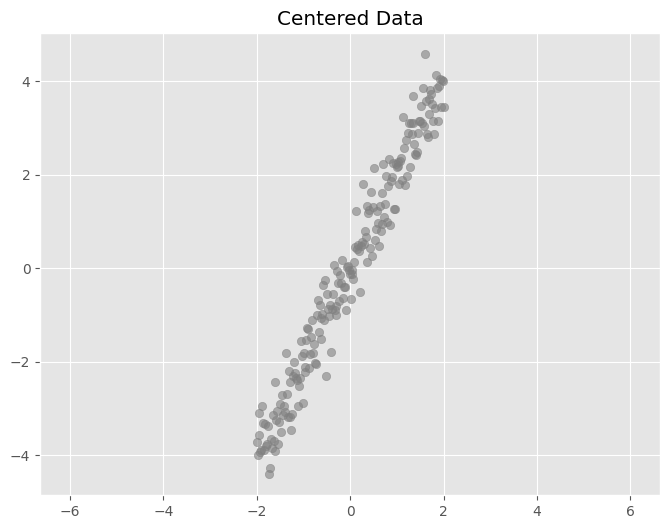

In [6]:
# 0. Generate Synthetic Correlated Data
np.random.seed(42)
n_samples = 200

# Create data where Y is correlated with X (y = 2x + noise)
X_clean = np.linspace(-2, 2, n_samples)
Y_clean = 2 * X_clean + np.random.normal(0, 0.5, n_samples)

data = np.vstack([X_clean, Y_clean]).T

# 1. Center the Data
mean_vector = np.mean(data, axis=0)
data_centered = data - mean_vector

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(data_centered[:, 0], data_centered[:, 1], alpha=0.6, color='gray')
plt.title("Centered Data")
plt.axis('equal')
plt.show()

### Calculating Covariance & Eigenvectors
The eigenvectors point in the direction of the spread.

Covariance Matrix:
 [[1.35 2.75]
 [2.75 5.79]]

Top Eigenvalue (Variance): 7.097387830584306
Top Eigenvector (Direction): [-0.43 -0.9 ]


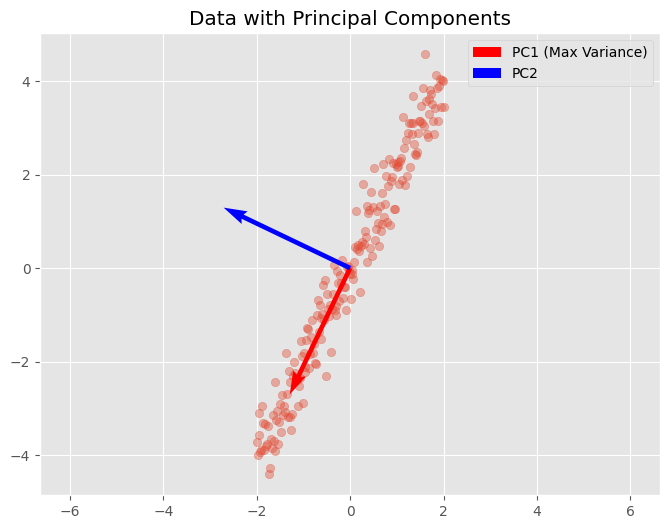

In [7]:
# 2. Compute Covariance Matrix
cov_matrix = np.cov(data_centered, rowvar=False)
print("Covariance Matrix:\n", cov_matrix)

# 3. Eigen Decomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort by eigenvalue (Descending)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

print("\nTop Eigenvalue (Variance):", eigenvalues[0])
print("Top Eigenvector (Direction):", eigenvectors[:, 0])

# Visualizing the Principal Components
plt.figure(figsize=(8, 6))
plt.scatter(data_centered[:, 0], data_centered[:, 1], alpha=0.4)

# Plot PC1 (Red) and PC2 (Blue)
origin = [0, 0]
plt.quiver(*origin, *eigenvectors[:, 0] * 3, color='r', scale=1, scale_units='xy', angles='xy', label='PC1 (Max Variance)')
plt.quiver(*origin, *eigenvectors[:, 1] * 3, color='b', scale=1, scale_units='xy', angles='xy', label='PC2')

plt.axis('equal')
plt.legend()
plt.title("Data with Principal Components")
plt.show()

---
## Part 4: PCA Application (MNIST)

We will now use PCA to compress images of handwritten digits (8x8 pixels = 64 dimensions).

**The Question:** Can we represent a 64-pixel image with fewer numbers (e.g., 10 or 20)?

In [8]:
# Load Data
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"Dataset Shape: {X_digits.shape} (1797 images, 64 pixels each)")

# 1. Center the data
X_mean = np.mean(X_digits, axis=0)
X_centered = X_digits - X_mean

# 2. PCA via Numpy (Cov -> Eig)
cov_digits = np.cov(X_centered, rowvar=False)
eig_vals, eig_vecs = np.linalg.eigh(cov_digits) # eigh for symmetric matrices

# Sort descending
sorted_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sorted_idx]
eig_vecs = eig_vecs[:, sorted_idx]

Dataset Shape: (1797, 64) (1797 images, 64 pixels each)


### 4.1 The Scree Plot
This plot shows how much "variance" (information) each Principal Component holds. We look for an "elbow" to decide how many components to keep.

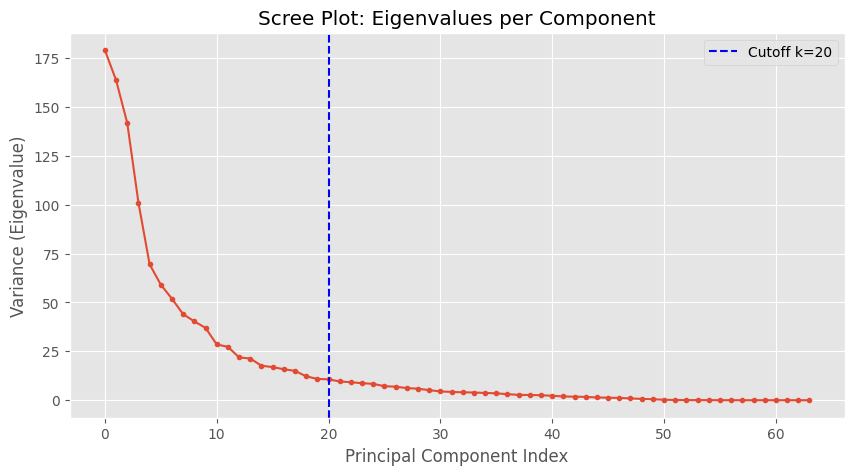

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(eig_vals, marker='o', markersize=3)
plt.title("Scree Plot: Eigenvalues per Component")
plt.xlabel("Principal Component Index")
plt.ylabel("Variance (Eigenvalue)")
plt.axvline(x=20, color='b', linestyle='--', label='Cutoff k=20')
plt.legend()
plt.show()

### 4.2 Eigen-Digits
Since the eigenvectors live in the same 64-dimensional space as the images, we can visualize them as images! These are the "basic ingredients" of a digit.

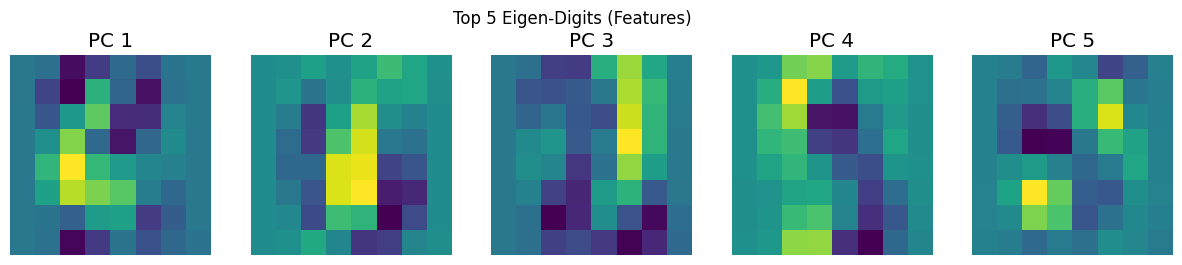

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    # Reshape the i-th eigenvector to 8x8 image
    eigen_image = eig_vecs[:, i].reshape(8, 8)
    ax.imshow(eigen_image, cmap='viridis')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')
plt.suptitle("Top 5 Eigen-Digits (Features)")
plt.show()

### 4.3 Compression & Reconstruction
We will project a digit down to $k$ dimensions and then try to reconstruct it.

$$ Z = X \cdot U_k $$
$$ X_{rec} = Z \cdot U_k^T + \mu $$

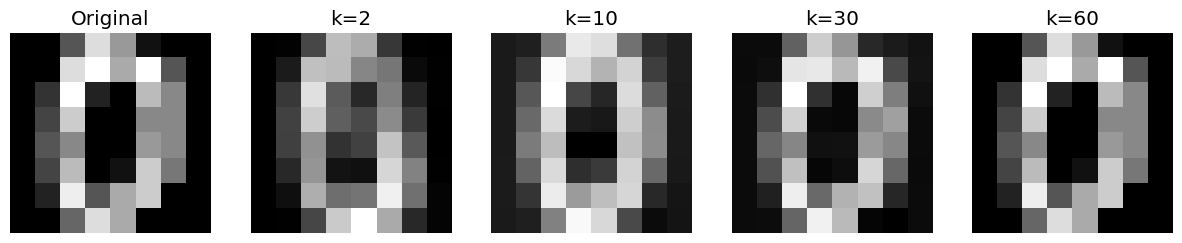

In [11]:
def reconstruction_demo(image_idx, k_list):
    original_img = X_centered[image_idx]

    plt.figure(figsize=(15, 3))

    # Plot Original
    plt.subplot(1, len(k_list)+1, 1)
    plt.imshow(digits.images[image_idx], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    for i, k in enumerate(k_list):
        # 1. Select top k eigenvectors (Projection Matrix)
        U_k = eig_vecs[:, :k]

        # 2. Project (Compress)
        z = np.dot(original_img, U_k)

        # 3. Reconstruct (Expand)
        img_rec = np.dot(z, U_k.T) + X_mean

        plt.subplot(1, len(k_list)+1, i+2)
        plt.imshow(img_rec.reshape(8, 8), cmap='gray')
        plt.title(f"k={k}")
        plt.axis('off')

    plt.show()

# Run Demo
reconstruction_demo(image_idx=0, k_list=[2, 10, 30, 60])